# 1) Dataset

As bases de dados utilizadas são provenientes do **Banco Central do Brasil (BCB)**, mais especificamente do **Sistema Gerenciador de Séries Temporais (SGS)**.

### Fontes de dados:
- **Sistema Gerenciador de Séries Temporais (SGS/BCB):**  
  [Acessar SGS/BCB](https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries)

- **Tabela de estatísticas monetárias e de crédito**  
  (contém algumas séries administradas pelo SGS em formato `.xlsx`):  
  [Acessar estatísticas monetárias e de crédito](https://www.bcb.gov.br/estatisticas/estatisticasmonetariascredito)


## Coletando as séries do Sistema Gerenciador de Séries Temporais / BCB

In [1]:
# ====== Imports ======
import time
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from pathlib import Path

# Modelagem
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:

# ====== Funções utilitárias ======

URL_BASE = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo}/dados"

def baixar_serie_sgs(codigo: int, data_inicio: str, data_fim: str, tentativas_max: int = 5) -> pd.DataFrame:
    """
    Baixa UMA série do SGS em JSON e devolve DataFrame com ['data', f'sgs_{codigo}'] em frequência mensal (MS).
    data_inicio/data_fim no formato 'dd/mm/aaaa'.
    """
    params = {"formato": "json", "dataInicial": data_inicio, "dataFinal": data_fim}
    for tentativa in range(tentativas_max):
        try:
            resp = requests.get(
                URL_BASE.format(codigo=codigo),
                params=params,
                timeout=30,
                headers={"User-Agent": "tcc-credito/1.0"}
            )
            resp.raise_for_status()
            bruto = resp.json()
            df = pd.DataFrame(bruto)
            if df.empty:
                return pd.DataFrame(columns=["data", f"sgs_{codigo}"])

            # parse de datas: "dd/mm/aaaa" ou "mm/aaaa"
            def parse_data(s):
                for fmt in ("%d/%m/%Y", "%m/%Y"):
                    try:
                        return datetime.strptime(s, fmt)
                    except ValueError:
                        pass
                return pd.NaT

            df["data"] = df["data"].apply(parse_data)
            df[f"sgs_{codigo}"] = pd.to_numeric(df["valor"].str.replace(",", "."), errors="coerce")
            saida = (
                df[["data", f"sgs_{codigo}"]]
                .dropna(subset=["data"])
                .set_index("data")
                .sort_index()
                .asfreq("MS")   # início do mês
            ).reset_index()
            return saida

        except requests.RequestException as e:
            time.sleep(2 ** tentativa)
            if tentativa == tentativas_max - 1:
                raise e

def baixar_varias_series(codigos: list[int], data_inicio: str, data_fim: str) -> pd.DataFrame:
    """Faz merge (outer) por 'data' e retorna índice mensal (MS)."""
    tabela = None
    for codigo in codigos:
        df = baixar_serie_sgs(codigo, data_inicio, data_fim)
        tabela = df if tabela is None else tabela.merge(df, on="data", how="outer")
    tabela = tabela.set_index("data").sort_index().asfreq("MS")
    return tabela

# Transformações
def variacao_12m_pct(serie: pd.Series, k: int = 12) -> pd.Series:
    """Variação percentual em 12 meses (YoY)."""
    return 100 * (serie / serie.shift(k) - 1)

def soma_movel_12m(serie: pd.Series) -> pd.Series:
    """Soma móvel de 12 meses (ex.: para mensal virar 12m)."""
    return serie.rolling(12, min_periods=12).sum()

def adicionar_defasagens(df: pd.DataFrame, colunas: list[str], lags: list[int]) -> pd.DataFrame:
    """Cria colunas defasadas: coluna_lagK = coluna deslocada K meses para trás."""
    for c in colunas:
        for k in lags:
            df[f"{c}_lag{k}"] = df[c].shift(k)
    return df

def adicionar_alvos_futuros(df: pd.DataFrame, colunas_alvo: list[str], horizontes: list[int]) -> pd.DataFrame:
    """Cria colunas de alvo no futuro: alvo_t+H = coluna deslocada H meses para frente (lead)."""
    for c in colunas_alvo:
        for h in horizontes:
            df[f"{c}_t+{h}"] = df[c].shift(-h)
    return df

# --- Imports compatíveis com versões 1.0–1.x do scikit-learn ---
try:
    from sklearn.metrics import root_mean_squared_error as _rmse_metric  # >= 1.4
except ImportError:  # versões mais antigas
    from sklearn.metrics import mean_squared_error as _mse_metric
    def _rmse_metric(y_true, y_pred):
        # fallback sem o parâmetro deprecated no seu código
        return _mse_metric(y_true, y_pred, squared=False)

def rmse_score(y_true, y_pred):
    """RMSE com alinhamento por índice (mesma amostra)."""
    y_true = pd.Series(y_true, dtype=float)
    y_pred = pd.Series(y_pred, dtype=float)
    idx = y_true.index.intersection(y_pred.index)
    y_true = y_true.loc[idx]
    y_pred = y_pred.loc[idx]
    return float(_rmse_metric(y_true, y_pred))

## Coletando as séries do Sistema Gerenciador de Séries Temporais / BCB

In [3]:
# ====== Séries e datas ======
CODIGOS = {
    # Estoques (nível)
    "saldo_total": 20539,
    "saldo_pj":    20540,
    "saldo_pf":    20541,
    # Inadimplência (% carteira, >=90 dias)
    "inad_total":  21082,
    "inad_pj":     21083,
    "inad_pf":     21084,
    # Taxas médias (novas operações, % a.a. do mês)
    "taxa_total":  20714,
    "taxa_pj":     20715,  # (não vamos usar em PF t+3; mantido só para eventual consulta)
    "taxa_pf":     20716,  # (idem)
    # Política monetária
    "selic_252":   4189,   # Selic acumulada no mês, anualizada base 252
}

DATA_INICIO = "01/01/2021"
DATA_FIM    = datetime.today().strftime("%d/%m/%Y")

In [4]:
todos = list(CODIGOS.values())
bruto = baixar_varias_series(todos, DATA_INICIO, DATA_FIM)

# Renomear colunas sgs_XXXX -> nomes amigáveis
mapa = {f"sgs_{v}": k for k, v in CODIGOS.items()}
dados = bruto.rename(columns=mapa).copy()

# Preencher buracos pontuais (após merge)
dados = dados.ffill()

# ===== Transformações principais =====
dados["saldo_total_var12m"] = variacao_12m_pct(dados["saldo_total"])
dados["saldo_pf_var12m"]    = variacao_12m_pct(dados["saldo_pf"])
dados["saldo_pj_var12m"]    = variacao_12m_pct(dados["saldo_pj"])

# ===== Defasagens (PF t+3: lags CURTOS e sem 0-lag) =====
# Juros / preço do crédito (fortes em 1–3m para PF)
dados = adicionar_defasagens(dados, ["selic_252"], lags=[1, 3])
dados = adicionar_defasagens(dados, ["taxa_total"], lags=[1, 3])

# Ciclo de carteira (opcional para PF; manter 1–3 para testar ganho)
dados = adicionar_defasagens(dados, ["saldo_pf_var12m", "saldo_pj_var12m"], lags=[1, 3])

# ===== Alvo no futuro (APENAS t+3 e APENAS PF) =====
dados = adicionar_alvos_futuros(dados, ["inad_pf"], horizontes=[3])

# Persistir a base preparada
dados.to_csv("base_sgs.csv")
dados

,saldo_total,saldo_pj,saldo_pf,inad_total,inad_pj,inad_pf,taxa_total,taxa_pj,taxa_pf,selic_252,...,saldo_pj_var12m,selic_252_lag1,selic_252_lag3,taxa_total_lag1,taxa_total_lag3,saldo_pf_var12m_lag1,saldo_pf_var12m_lag3,saldo_pj_var12m_lag1,saldo_pj_var12m_lag3,inad_pf_t+3
data,,,,,,,,,,,,,,,,,,,,,
2021-01-01,4017481.0,1764350.0,2253131.0,2.14,1.20,2.88,19.90,13.63,23.80,1.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.91
2021-02-01,4044845.0,1774313.0,2270532.0,2.23,1.35,2.92,19.62,12.32,24.16,1.90,...,NaN,1.90,NaN,19.90,NaN,NaN,NaN,NaN,NaN,2.97
2021-03-01,4106449.0,1809384.0,2297064.0,2.13,1.20,2.87,19.79,12.31,24.48,2.23,...,NaN,1.90,NaN,19.62,NaN,NaN,NaN,NaN,NaN,2.87
2021-04-01,4126914.0,1804880.0,2322034.0,2.19,1.27,2.91,20.26,13.04,24.75,2.65,...,NaN,2.23,1.90,19.79,19.90,NaN,NaN,NaN,NaN,2.90
2021-05-01,4175472.0,1814790.0,2360682.0,2.33,1.51,2.97,19.79,12.75,24.11,3.29,...,NaN,2.65,1.90,20.26,19.62,NaN,NaN,NaN,NaN,2.92
2021-06-01,4212400.0,1814263.0,2398138.0,2.27,1.48,2.87,19.92,12.93,24.18,3.76,...,NaN,3.29,2.23,19.79,19.79,NaN,NaN,NaN,NaN,2.97
2021-07-01,4269669.0,1830524.0,2439145.0,2.31,1.52,2.90,20.30,13.87,24.15,4.15,...,NaN,3.76,2.65,19.92,20.26,NaN,NaN,NaN,NaN,2.95
2021-08-01,4344165.0,1848208.0,2495958.0,2.31,1.50,2.92,20.97,14.67,24.68,5.01,...,NaN,4.15,3.29,20.30,19.79,NaN,NaN,NaN,NaN,2.97
2021-09-01,4439121.0,1891192.0,2547929.0,2.28,1.36,2.97,21.46,15.11,25.24,5.43,...,NaN,5.01,3.76,20.97,19.92,NaN,NaN,NaN,NaN,3.00


# 2) EDA (Exploratory Data Analysis)

## 1. Definição
**EDA – Análise Exploratória de Dados** é a etapa inicial de um projeto de ciência de dados.  
Ela serve para **entender, limpar e organizar os dados** antes de aplicar modelos estatísticos ou de machine learning.  

👉 Em termos simples: é como "investigar" seus dados para descobrir padrões, erros, outliers (valores muito fora do normal) e relações entre variáveis.

## 2. Objetivos deste EDA
1. **Conhecer os dados**: período, amostra, valores faltantes e estatísticas básicas.
2. **Visualizar séries**: inadimplência PF/PJ, crescimento do saldo, Selic e taxas.
3. **Ver correlações com defasagens** (0, 1, 3, 6, 12) entre as explicativas e as metas (inad_pf e inad_pj).
4. **Checar estacionaridade** (ADF) e **olhar ACF/PACF** das metas.




In [5]:
# --- Recorte temporal a partir de 2022 ---
INICIO_ANALISE = pd.Timestamp("2022-01-01")  # para EDA
dados_analise = dados.loc[dados.index >= INICIO_ANALISE].copy()

# 1) Panorama geral (a partir de 2022)
print("Formato:", dados_analise.shape)
print("Período:", dados_analise.index.min().date(), "→", dados_analise.index.max().date())

faltantes = dados_analise.isna().sum().sort_values(ascending=False)
print("\nTop 20 variáveis com faltantes:")
print(faltantes.head(20))

print("\nEstatísticas básicas das principais variáveis:")
cols_stats = ["inad_pf","inad_pj","saldo_total_var12m","selic_252","taxa_total","taxa_pf","taxa_pj"]
print(dados_analise[cols_stats].describe().T)


Formato: (46, 22)
Período: 2022-01-01 → 2025-10-01

Top 20 variáveis com faltantes:
saldo_pf_var12m_lag3    3
inad_pf_t+3             3
saldo_pj_var12m_lag3    3
saldo_pf_var12m_lag1    1
saldo_pj_var12m_lag1    1
saldo_total             0
inad_pf                 0
inad_pj                 0
inad_total              0
saldo_pf                0
saldo_pj                0
taxa_total              0
taxa_pf                 0
taxa_pj                 0
selic_252_lag1          0
saldo_pj_var12m         0
saldo_pf_var12m         0
saldo_total_var12m      0
selic_252               0
taxa_total_lag3         0
dtype: int64

Estatísticas básicas das principais variáveis:
                    count       mean       std        min        25%  \
inad_pf              46.0   3.880217  0.360219   3.210000   3.660000   
inad_pj              46.0   2.190652  0.447975   1.360000   1.730000   
saldo_total_var12m   46.0  12.007467  3.064172   7.692153   9.546731   
selic_252            46.0  12.600870  1.543209 

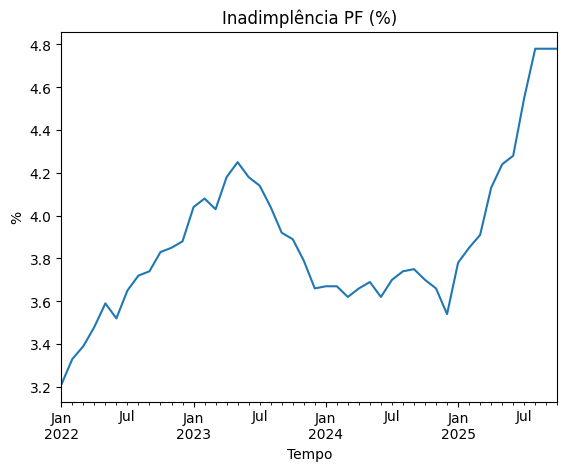

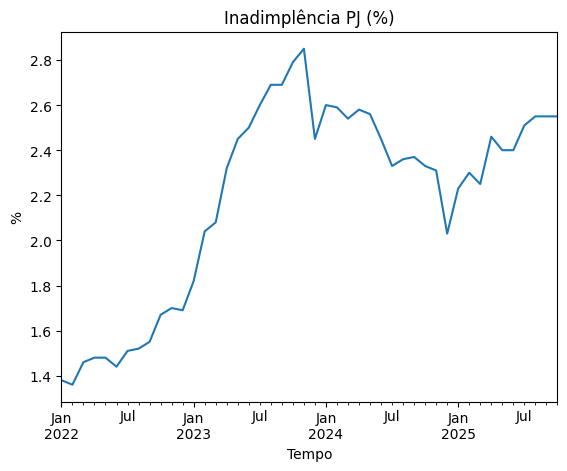

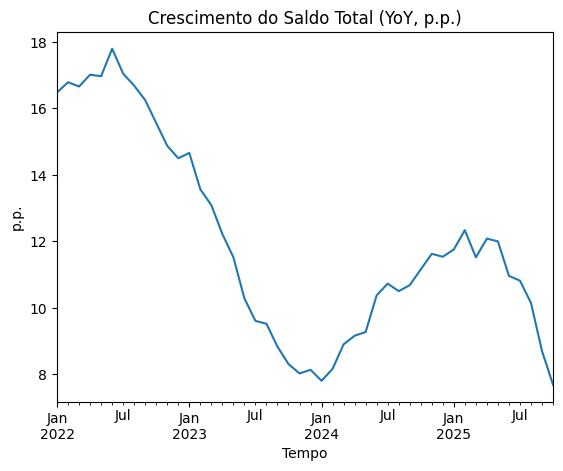

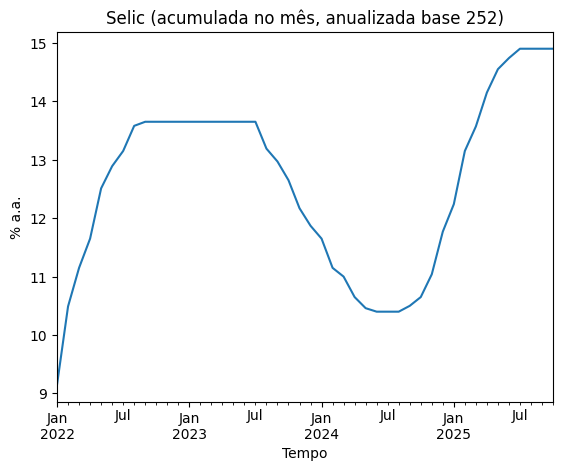

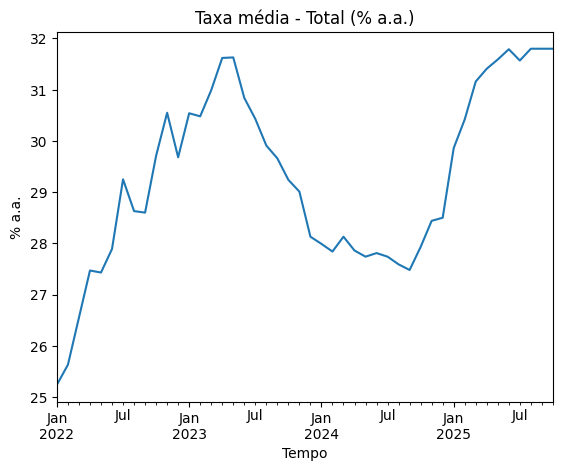

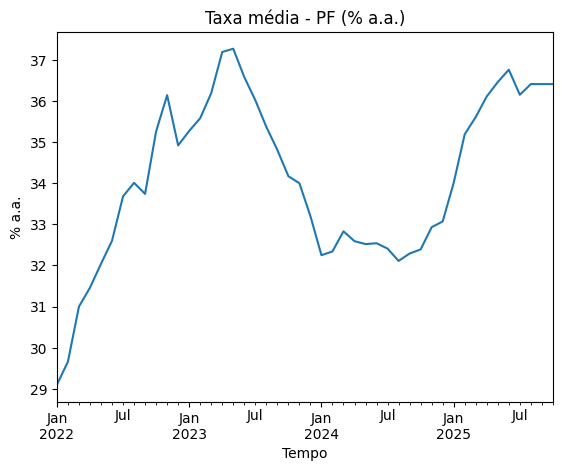

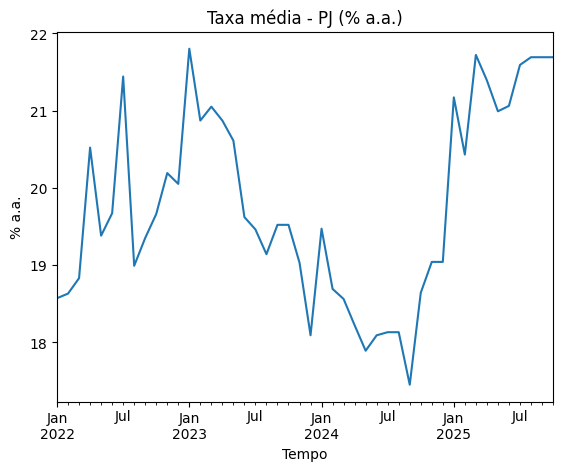

In [6]:
INICIO_ANALISE = pd.Timestamp("2022-01-01")
base_plot = dados.loc[dados.index >= INICIO_ANALISE].copy()

# 2) Visualizações (um gráfico por figura, sem estilos/cor específicos)
import matplotlib.pyplot as plt

def plota(df, col, titulo, ylabel):
    if col in df.columns:
        plt.figure()
        df[col].plot(title=titulo)
        plt.xlabel("Tempo"); plt.ylabel(ylabel)
        plt.show()

plota(base_plot, "inad_pf", "Inadimplência PF (%)", "%")
plota(base_plot, "inad_pj", "Inadimplência PJ (%)", "%")
plota(base_plot, "saldo_total_var12m", "Crescimento do Saldo Total (YoY, p.p.)", "p.p.")
plota(base_plot, "selic_252", "Selic (acumulada no mês, anualizada base 252)", "% a.a.")
plota(base_plot, "taxa_total", "Taxa média - Total (% a.a.)", "% a.a.")
plota(base_plot, "taxa_pf", "Taxa média - PF (% a.a.)", "% a.a.")
plota(base_plot, "taxa_pj", "Taxa média - PJ (% a.a.)", "% a.a.")

In [7]:
# 3) Correlações com defasagens — quais atrasos explicam melhor inad_pf e inad_pj?
from IPython.display import display, HTML
def display_dataframe_to_user(titulo: str, dataframe: pd.DataFrame):
        display(HTML(f"<h3>{titulo}</h3>"))
        display(dataframe)

def correlacao_com_lag(alvo: pd.Series, explicativa: pd.Series, lags=(0,1,3,6,12)):
    return {k: alvo.corr(explicativa.shift(k)) for k in lags}

explicativas_base = {
    "selic_252": base_plot["selic_252"],
    "taxa_total": base_plot["taxa_total"],
    "taxa_pf": base_plot["taxa_pf"],
    "taxa_pj": base_plot["taxa_pj"],
    "saldo_pf_var12m": base_plot["saldo_pf_var12m"],
    "saldo_pj_var12m": base_plot["saldo_pj_var12m"],
}

linhas = []
for nome, serie in explicativas_base.items():
    corr_pf = correlacao_com_lag(base_plot["inad_pf"], serie)
    corr_pj = correlacao_com_lag(base_plot["inad_pj"], serie)
    for k in [0,1,3,6,12]:
        linhas.append({"variavel": nome, "lag": k,
                       "corr_inad_pf": corr_pf[k], "corr_inad_pj": corr_pj[k]})

tabela_corr = pd.DataFrame(linhas).sort_values(["variavel","lag"])
tabela_corr

,variavel,lag,corr_inad_pf,corr_inad_pj
20,saldo_pf_var12m,0,-0.455266,-0.945795
21,saldo_pf_var12m,1,-0.332082,-0.923808
22,saldo_pf_var12m,3,-0.122850,-0.842661
23,saldo_pf_var12m,6,0.065853,-0.642067
24,saldo_pf_var12m,12,0.009781,0.116959
25,saldo_pj_var12m,0,-0.224479,-0.764006
26,saldo_pj_var12m,1,-0.039001,-0.753975
27,saldo_pj_var12m,3,0.305898,-0.676838
28,saldo_pj_var12m,6,0.581075,-0.502713
29,saldo_pj_var12m,12,0.373291,0.292184


Teste ADF das metas/endógenas:
inad_pf (nível): ADF=-1.606, p-valor=0.4806, lags_usados=3, n_obs=42
inad_pj (nível): ADF=-1.844, p-valor=0.3590, lags_usados=3, n_obs=42
saldo_total_var12m (taxa YoY): ADF=-1.884, p-valor=0.3395, lags_usados=3, n_obs=42
Lags usados — inad_pf: ACF=24, PACF=22
Lags usados — inad_pj: ACF=24, PACF=22


<Figure size 640x480 with 0 Axes>

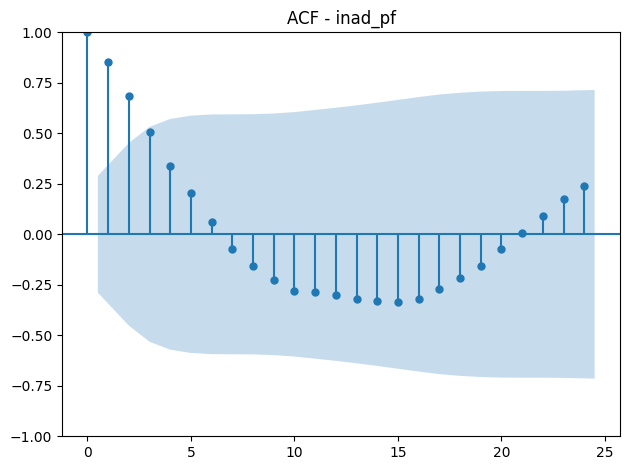

<Figure size 640x480 with 0 Axes>

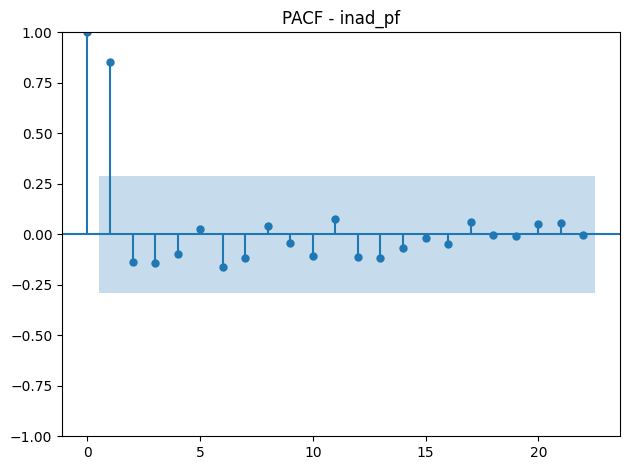

<Figure size 640x480 with 0 Axes>

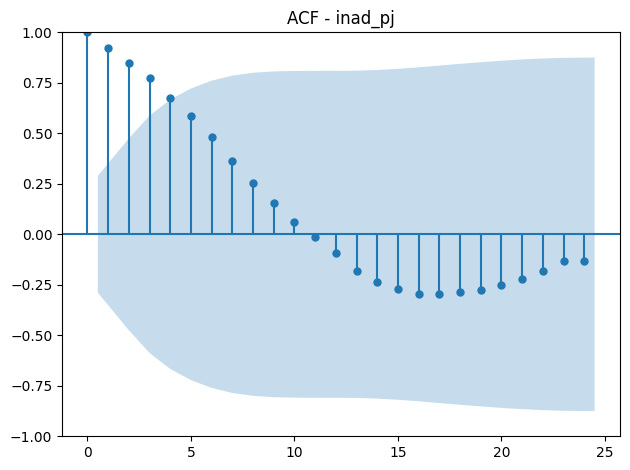

<Figure size 640x480 with 0 Axes>

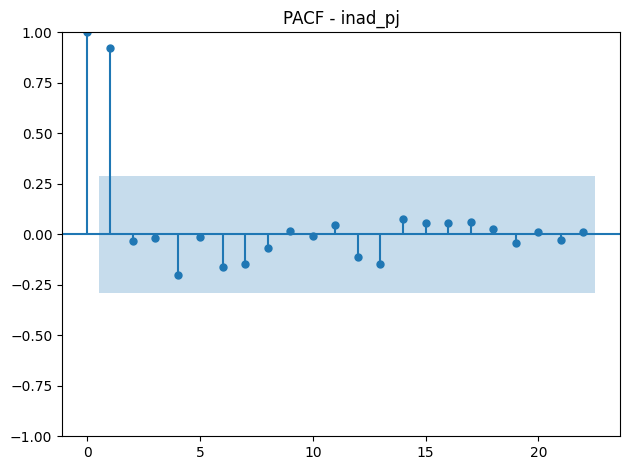

In [8]:
# 4) Teste ADF (estacionaridade) e ACF/PACF

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd

def resumo_adf(serie, nome):
    serie_clean = pd.to_numeric(pd.Series(serie), errors="coerce").dropna()
    if len(serie_clean) < 25:
        print(f"{nome}: série muito curta para ADF (n={len(serie_clean)})")
        return
    res = adfuller(serie_clean, autolag='AIC')
    print(f"{nome}: ADF={res[0]:.3f}, p-valor={res[1]:.4f}, lags_usados={res[2]}, n_obs={res[3]}")

def lags_acf_max(serie, desejado=24):
    n = pd.to_numeric(pd.Series(serie), errors="coerce").dropna().shape[0]
    # ACF pode ir até n-2; usamos um bound seguro
    return max(1, min(desejado, n - 2))

def lags_pacf_max(serie, desejado=24):
    n = pd.to_numeric(pd.Series(serie), errors="coerce").dropna().shape[0]
    # PACF exige nlags < n/2 -> usar (n//2 - 1) como limite superior
    return max(1, min(desejado, (n // 2) - 1))

print("Teste ADF das metas/endógenas:")
resumo_adf(base_plot["inad_pf"], "inad_pf (nível)")
resumo_adf(base_plot["inad_pj"], "inad_pj (nível)")
resumo_adf(base_plot["saldo_total_var12m"], "saldo_total_var12m (taxa YoY)")

# --- ACF/PACF com limites dinâmicos ---
serie_pf = pd.to_numeric(base_plot["inad_pf"], errors="coerce").dropna()
serie_pj = pd.to_numeric(base_plot["inad_pj"], errors="coerce").dropna()

lags_pf_acf  = lags_acf_max(serie_pf, 24)
lags_pf_pacf = lags_pacf_max(serie_pf, 24)
lags_pj_acf  = lags_acf_max(serie_pj, 24)
lags_pj_pacf = lags_pacf_max(serie_pj, 24)

print(f"Lags usados — inad_pf: ACF={lags_pf_acf}, PACF={lags_pf_pacf}")
print(f"Lags usados — inad_pj: ACF={lags_pj_acf}, PACF={lags_pj_pacf}")

plt.figure()
plot_acf(serie_pf, lags=lags_pf_acf)
plt.title("ACF - inad_pf")
plt.tight_layout(); plt.show()

plt.figure()
try:
    plot_pacf(serie_pf, lags=lags_pf_pacf, method="ywm")
except TypeError:
    # fallback se sua versão não suportar "ywm"
    plot_pacf(serie_pf, lags=lags_pf_pacf, method="yw")
plt.title("PACF - inad_pf")
plt.tight_layout(); plt.show()

plt.figure()
plot_acf(serie_pj, lags=lags_pj_acf)
plt.title("ACF - inad_pj")
plt.tight_layout(); plt.show()

plt.figure()
try:
    plot_pacf(serie_pj, lags=lags_pj_pacf, method="ywm")
except TypeError:
    plot_pacf(serie_pj, lags=lags_pj_pacf, method="yw")
plt.title("PACF - inad_pj")
plt.tight_layout(); plt.show()


# 3) Modelos Tradicionais

In [ ]:
# ==== ARIMAX (SARIMAX) para inad_pf t+3 (modelo direto) ====
H = 3
INICIO_TREINO = pd.Timestamp("2022-04-01")  # evita que lag1/lag3 alcancem 2021

# memória do alvo (se ainda não existirem)
base_plot["inad_pf_lag1"] = base_plot["inad_pf"].shift(1)
base_plot["inad_pf_lag3"] = base_plot["inad_pf"].shift(3)

# alvo direto
base_plot[f"inad_pf_t+{H}"] = base_plot["inad_pf"].shift(-H)

# features parcimoniosas (PF t+3)
FEATURES = [
    "taxa_total_lag1","taxa_total_lag3",
    "selic_252_lag1","selic_252_lag3",
    "inad_pf_lag1","inad_pf_lag3",
]
TARGET = f"inad_pf_t+{H}"

# dataset limpo, MESMA AMOSTRA para todas as métricas
df_model = base_plot[[TARGET] + FEATURES].loc[INICIO_TREINO:].dropna()

y = df_model[TARGET]
X = df_model[FEATURES]

# split temporal 80/20
n = len(df_model); n_tr = int(n*0.8)
y_train, y_test = y.iloc[:n_tr], y.iloc[n_tr:]
X_train, X_test = X.iloc[:n_tr], X.iloc[n_tr:]

# SARIMAX: endog é o alvo deslocado (modelo direto para H passos)
model = SARIMAX(endog=y_train, exog=X_train, order=(1,0,0),
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)

# previsão no período de teste usando exógenas conhecidas
y_pred_test = res.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

# avaliação básica (se não tiver a função pronta)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = rmse_score(y_test, y_pred_test)
scores = {"H=3_inad_pf": {"MAE": mae, "RMSE": rmse}}
scores

{'H=3_inad_pf': {'MAE': 0.44920129755080507, 'RMSE': 0.5085476796165578}}

In [10]:
# ====== Salvar dataset pronto e resultados ======
Path("dados").mkdir(exist_ok=True)
dados.to_parquet("dados/base_tcc.parquet")
dados.to_csv("dados/base_tcc.csv", index=True)

print("Arquivos salvos em 'dados/':")
for f in ["dados/base_tcc.parquet", "dados/base_tcc.csv"]:
    print(" -", f)

Arquivos salvos em 'dados/':
 - dados/base_tcc.parquet
 - dados/base_tcc.csv


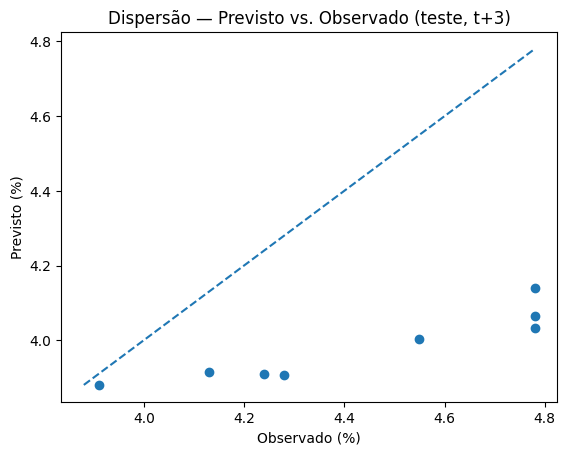

In [25]:
# ====== GRÁFICOS E AVALIAÇÃO (teste) ======
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# 3) Dispersão Previsto × Observado (teste)
plt.figure()
plt.scatter(y_test, y_pred_test)
plt.title("Dispersão — Previsto vs. Observado (teste, t+3)")
plt.xlabel("Observado (%)"); plt.ylabel("Previsto (%)")
# linha 45º para referência visual
mn = np.nanmin([y_test.min(), y_pred_test.min()])
mx = np.nanmax([y_test.max(), y_pred_test.max()])
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.show()

In [23]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

residuos = (y_test - y_pred_test)
m, b = np.polyfit(y_test, y_pred_test, 1)  # regressão Previsto ~ Observado

print({
    "MAE": float(mean_absolute_error(y_test, y_pred_test)),
    "RMSE": float(rmse_score(y_test, y_pred_test)),
    "R2_teste": float(r2_score(y_test, y_pred_test)),
    "Viés_médio (obs - prev)": float(residuos.mean()),
    "Inclinação_prev~obs": float(m),  # ideal≈1
    "Intercepto": float(b)            # ideal≈0
})


{'MAE': 0.34589009992771147, 'RMSE': 0.39219975467597673, 'R2_teste': -0.5365019188627245, 'Viés_médio (obs - prev)': 0.34589009992771147, 'Inclinação_prev~obs': 0.4205631120576726, 'Intercepto': 2.2217396097667272}


In [13]:

# ====== Padronização de nomes de lags (sufixo _lagK) ======
import re
import pandas as pd

try:
    lags_map
except NameError:
    # conjunto parcimonioso recomendado
    lags_map = {
        "selic_252": [1,3,6,12],
        "taxa_total": [1,3,6],
        "saldo_pf_var12m": [1,3,6],
        "saldo_pj_var12m": [1,3,6],
    }

try:
    df_h
except NameError:
    df_h = dados.copy().sort_index()

# cria colunas padronizadas com _lagK quando faltarem
for var, ks in lags_map.items():
    if var not in df_h.columns:
        continue
    for k in ks:
        col = f"{var}_lag{k}"
        if col not in df_h.columns:
            df_h[col] = df_h[var].shift(k)

cols_lag = [c for c in df_h.columns if re.search(r"_lag\d+$", c)]
print("Total de colunas com sufixo _lagK:", len(cols_lag))
print(sorted(cols_lag)[:20], "...")


Total de colunas com sufixo _lagK: 13
['saldo_pf_var12m_lag1', 'saldo_pf_var12m_lag3', 'saldo_pf_var12m_lag6', 'saldo_pj_var12m_lag1', 'saldo_pj_var12m_lag3', 'saldo_pj_var12m_lag6', 'selic_252_lag1', 'selic_252_lag12', 'selic_252_lag3', 'selic_252_lag6', 'taxa_total_lag1', 'taxa_total_lag3', 'taxa_total_lag6'] ...


In [14]:

# ====== Features usadas e export dos resultados (t+3) ======
from pathlib import Path
import pandas as pd

# Detecta X_train/X_test e y_test gerados anteriormente
if 'X_test' in globals() and 'y_test' in globals():
    # Lista de features
    try:
        print("Nº de features (treino):", X_train.shape[1])
    except Exception:
        pass
    print("Nº de features (teste):", X_test.shape[1])
    print("Features usadas (primeiras 30):", list(X_test.columns)[:30])

    # Gera previsões se ainda não existirem
    if 'y_pred_test' not in globals():
        try:
            y_pred_test = res.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)
        except Exception as e:
            print("Não foi possível gerar y_pred_test automaticamente:", e)

    if 'y_pred_test' in globals():
        resultado_teste = (
            y_test.to_frame("observado")
                  .assign(previsto = y_pred_test.reindex(y_test.index))
        )
        Path("resultados").mkdir(exist_ok=True)
        out_csv = "resultados/observado_previsto_inad_pf_t+3.csv"
        resultado_teste.to_csv(out_csv, index=True)
        print("Arquivo salvo:", out_csv)
        try:
            display(resultado_teste.tail())
        except Exception:
            print("Prévia (tail):")
            print(resultado_teste.tail())
    else:
        print("Defina y_pred_test antes de rodar esta célula.")
else:
    print("Defina X_test e y_test antes de rodar esta célula.")


Nº de features (treino): 6
Nº de features (teste): 6
Features usadas (primeiras 30): ['taxa_total_lag1', 'taxa_total_lag3', 'selic_252_lag1', 'selic_252_lag3', 'inad_pf_lag1', 'inad_pf_lag3']
Arquivo salvo: resultados/observado_previsto_inad_pf_t+3.csv


,observado,previsto
data,,
2025-03-01,4.28,4.018984
2025-04-01,4.55,4.172938
2025-05-01,4.78,4.183727
2025-06-01,4.78,4.234812
2025-07-01,4.78,4.255829
